In [1]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import contextily as ctx

from utils import init_postgis, get_location_error, crop_route, get_total_distance

In [2]:
matplotlib.rcParams['timezone'] = 'Asia/Singapore'

In [3]:
date = '21-06-2024'

In [4]:
input_dir = f"../data/{date}"
output_dir = f"../metadata/{date}"

In [7]:
start_location = (1.352890590409223, 103.87639391445747)
stop_location = (1.3420763847358055, 103.83489321055718)

In [8]:
init_postgis('gpx_route', input_dir + '/route.gpx')
init_postgis('polar_route', input_dir + '/polar.gpx')
init_postgis('garmin_route', input_dir + '/garmin.gpx')

In [9]:
garmin_df = get_location_error('garmin_route')
garmin_df.head(3)

,time,latitude,longitude,distance_to_route
0,2024-06-21 22:18:54+08:00,1.350337,103.873950,389.388133
1,2024-06-21 22:19:02+08:00,1.350357,103.874004,383.682412
2,2024-06-21 22:19:17+08:00,1.350333,103.874126,376.664598


In [10]:
polar_df = get_location_error('polar_route')
polar_df.head(3)

,time,latitude,longitude,distance_to_route
0,2024-06-21 22:19:51.520000+08:00,1.350628,103.874462,327.469039
1,2024-06-21 22:19:52.521000+08:00,1.350628,103.874462,327.469039
2,2024-06-21 22:19:53.522000+08:00,1.350648,103.874470,325.160664


In [11]:
garmin_df = crop_route(garmin_df, start_location, stop_location, 200)
garmin_df.head(3)

,time,latitude,longitude,distance_to_route,start_distance,stop_distance
49,2024-06-21 22:23:02+08:00,1.352921,103.876459,14.566560,8.009313,4778.726811
50,2024-06-21 22:23:08+08:00,1.353008,103.876333,7.896098,14.594920,4767.592547
51,2024-06-21 22:23:13+08:00,1.353093,103.876199,3.640094,31.182549,4755.519613


In [12]:
polar_df = crop_route(polar_df, start_location, stop_location, 600)
polar_df.head(3)

,time,latitude,longitude,distance_to_route,start_distance,stop_distance
187,2024-06-21 22:23:04.522000+08:00,1.352952,103.876400,9.693065,6.787740,4773.208033
188,2024-06-21 22:23:05.522000+08:00,1.352965,103.876362,7.170637,8.976311,4769.451907
189,2024-06-21 22:23:06.521000+08:00,1.352980,103.876328,5.366768,12.288800,4766.281075


In [13]:
desc_polar_df = polar_df['distance_to_route'].describe().to_frame()
desc_polar_df.columns = ['Polar']

desc_garmin_df = garmin_df['distance_to_route'].describe().to_frame()
desc_garmin_df.columns = ['Garmin']

merged_desc = pd.concat([desc_polar_df, desc_garmin_df], axis=1)
merged_desc.to_csv('/tmp/merged_desc.csv')

print(merged_desc)

              Polar       Garmin
count  16253.000000  3392.000000
mean      11.143294     9.562684
std       14.644798    15.032557
min        0.000238     0.000314
25%        3.395202     2.179108
50%        7.088469     4.907120
75%       13.014246    10.213290
max      128.079562   129.955273


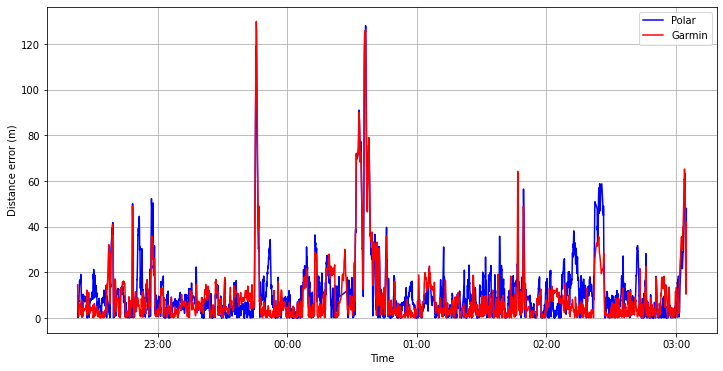

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(polar_df['time'], polar_df['distance_to_route'], color='blue', label='Polar')
plt.plot(garmin_df['time'], garmin_df['distance_to_route'], color='red', label='Garmin')
plt.xlabel('Time')
plt.ylabel('Distance error (m)')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.savefig(output_dir + '/location-error.png', bbox_inches='tight', facecolor='white')

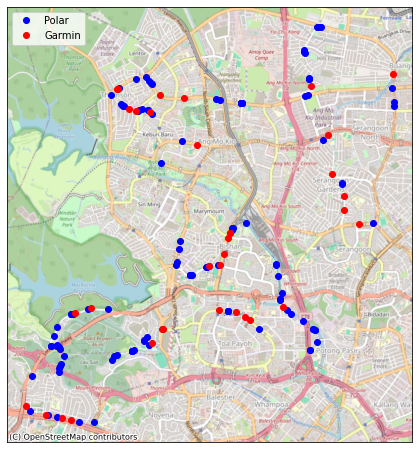

In [15]:
distance_error_threshold = 0.1
filtered_polar_df = polar_df[polar_df['distance_to_route'] <= distance_error_threshold]
filtered_garmin_df = garmin_df[garmin_df['distance_to_route'] <= distance_error_threshold]

plt.figure(figsize=(15, 8))
plt.plot(filtered_polar_df['longitude'], filtered_polar_df['latitude'], 'o', color='blue', label='Polar')
plt.plot(filtered_garmin_df['longitude'], filtered_garmin_df['latitude'], 'o', color='red', label='Garmin')
ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
plt.legend()
plt.xticks([], [])
plt.yticks([], [])
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
plt.savefig(output_dir + '/' + 'accurate-location.png', facecolor='white', bbox_inches='tight', pad_inches=0)

In [16]:
polar_df = get_total_distance(polar_df)
polar_df.iloc[-1]['accumulated_distance']

39967.135171940674

In [17]:
garmin_df = get_total_distance(garmin_df)
garmin_df.iloc[-1]['accumulated_distance']

38543.28616420372

In [18]:
polar_df.iloc[-1]['accumulated_distance'] - garmin_df.iloc[-1]['accumulated_distance']

1423.849007736957